In [1]:
import pandas as pd
import json
import os
import datetime as dt

In [2]:
FILE_FIRE_DATA = 'Seattle_Real_Time_Fire_911_Calls.csv'
FILE_WEATHER_DATA = 'Seattle Weatherdata 2002 to 2020.csv'

# Preprocessing

In [3]:
# this class does preprocessing and feature engineering of the provided "Seattle_Real_Time_Fire_911_Calls.csv" and "Seattle Weatherdata 2002 to 2020.csv"
# file1: path to first file
# file2: path to second file
# feature_set_1: list of the columns to read from file 1
# feature_set_2: list of the columns to read fomr file 2
# usage: call start_preprocessing function and use joined_data after that
class Preprocessing():
    def __init__(self, file1, file2, features_set_1, features_set_2):
        self.file1 = file1
        self.file2 = file2
        self.features_set_1 = features_set_1
        self.features_set_2 = features_set_2
        print('reading_files_start')
        self.fire_data = pd.read_csv(file1, parse_dates = ['Datetime'], usecols = features_set_1)
        self.weather_data = pd.read_csv(file2, usecols = features_set_2)
        print('reading_files_end')

    def start_preprocessing(self):
        # here order of the function calls matter
        print('--Preprocessing start--')
        self.preprocess_weather_data()
        self.format_datetime()
        self.pruning_data()
        self.make_target_feature()
        self.merging_data()
        self.split_date_time()
        
    def preprocess_weather_data(self):
        # most of the seasonal data (rain, wind, snow etc) contains empty values, but it is of use
        # therefore empty/null values can be replaced with 0
        self.weather_data = self.weather_data.fillna(0)
        
#         one_hot_encoding = pd.get_dummies(self.weather_data['weather_description'], prefix='weather')
#         self.weather_data = pd.concat([self.weather_data, one_hot_encoding], axis=1)
#         self.weather_data = self.weather_data.drop(columns = ['weather_description'])
        
    def format_datetime(self):
        print('--format datetime--')
        # format datetime to make it standard
        # in case of fire_data we want to use hourly information and discard information on minutes level
        self.fire_data['Datetime'] = self.fire_data['Datetime'].dt.strftime('%Y-%m-%d %H')
        # remove extra UTC info
        self.weather_data['dt_iso'] = self.weather_data['dt_iso'].str.replace('\+0000 UTC', '')
        # convert to datetime object and format
        self.weather_data['dt_iso'] = pd.to_datetime(self.weather_data['dt_iso'])
        self.weather_data['dt_iso'] = self.weather_data['dt_iso'].dt.strftime('%Y-%m-%d %H')
    
    def pruning_data(self):
        print('--data pruning--')
        # weather data is not updated and contains values till date 2020-11-05 00
        # therefore for simplicity I will use test year as 2019 and last five years starting from 2014 as train
        self.weather_data=self.weather_data[(self.weather_data['dt_iso']>='2014-01-01') & (self.weather_data['dt_iso']<'2020-01-01')]
        self.fire_data=self.fire_data[(self.fire_data['Datetime']>='2014-01-01') & (self.fire_data['Datetime']<'2020-01-01')]
    
    def make_target_feature(self):
        print('--make target feature--')
        # Group hourly data to get the count of calls per hour which will be our target feature
        # we can say that we are transforming data into supervised learning problem
        self.fire_data = pd.DataFrame(self.fire_data.groupby('Datetime')['Datetime'].count()).rename(columns = {'Datetime':'calls'}).reset_index()
        # weather data contains duplicate values of dates
        self.weather_data = self.weather_data.drop_duplicates(subset=['dt_iso'])
    def merging_data(self):
        print('--merging data--')
        ##checking if weather data contains each and every hour of every day in the time period by comparing length
        #date_rng = pd.DataFrame(pd.date_range(start='1/1/2014', end='31/12/2019', freq='H'))
        #date_rng.rename(columns={0:'Time'}, inplace=True)
        # Left-join of weather_data and fire_data in order to get complete features (whole data)
        self.joined_data = self.weather_data.merge(self.fire_data, how='left', left_on='dt_iso', right_on='Datetime')
        # filling null values with zeros
        self.joined_data = self.joined_data.fillna(0)
        self.joined_data.drop(columns=['Datetime'], inplace=True)
        self.joined_data = self.joined_data.sort_values(by='dt_iso')
    
    def split_date_time(self):
        print('--split date time--')
        #splitting datetime column into multiple column so that data information at individual level can be processed
        #by model
        self.joined_data['dt_iso'] = pd.to_datetime(self.joined_data['dt_iso'])
        self.joined_data['hour'] = self.joined_data['dt_iso'].dt.hour
        self.joined_data['dayofweek'] = self.joined_data['dt_iso'].dt.dayofweek
        self.joined_data['month'] = self.joined_data['dt_iso'].dt.month
        self.joined_data['year'] = self.joined_data['dt_iso'].dt.year
        self.joined_data['dayofyear'] = self.joined_data['dt_iso'].dt.dayofyear
        self.joined_data['dayofmonth'] = self.joined_data['dt_iso'].dt.day
        self.joined_data.drop(columns=['dt_iso'],inplace=True)
        
    
        
        
preprocessing = Preprocessing(FILE_FIRE_DATA, FILE_WEATHER_DATA, ['Datetime'], ['dt_iso', 'temp', 'pressure', 'humidity', 'wind_speed', 'wind_deg',
       'rain_1h', 'rain_3h', 'snow_1h', 'snow_3h', 'clouds_all'])

reading_files_start
reading_files_end


In [4]:
preprocessing.start_preprocessing()

--Preprocessing start--
--format datetime--
--data pruning--
--make target feature--
--merging data--
--split date time--


In [5]:
preprocessing.joined_data

,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,calls,hour,dayofweek,month,year,dayofyear,dayofmonth
0,7.03,1026,87,1.14,195,0.00,0.0,0.0,0.0,90,35.0,0,2,1,2014,1,1
1,6.66,1026,87,1.54,330,0.00,0.0,0.0,0.0,90,23.0,1,2,1,2014,1,1
2,6.28,1027,95,0.08,181,0.25,0.0,0.0,0.0,100,24.0,2,2,1,2014,1,1
3,5.92,1027,97,0.51,212,0.00,0.0,0.0,0.0,100,15.0,3,2,1,2014,1,1
4,5.87,1027,81,0.66,62,0.00,0.0,0.0,0.0,40,8.0,4,2,1,2014,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52579,9.04,1012,79,10.30,170,0.25,0.0,0.0,0.0,100,14.0,19,1,12,2019,365,31
52580,8.80,1012,82,4.10,190,0.73,0.0,0.0,0.0,100,16.0,20,1,12,2019,365,31
52581,8.79,1010,94,2.24,169,0.25,0.0,0.0,0.0,100,13.0,21,1,12,2019,365,31
52582,8.96,1009,82,6.70,190,0.25,0.0,0.0,0.0,100,12.0,22,1,12,2019,365,31


# Data class

In [6]:
# pass joined data
# data: dataframe of merge/join of both fire and weather data
class Data:
    def __init__(self, data: pd.DataFrame):
        self.data = data
    def get_train_test(self):
        # splitting into train and test data
        # train_data consists of data from year 2014 to 2018
        train_data = self.data[self.data['year']<2019]
        # test_data consists of year 2019
        test_data = self.data[self.data['year']==2019]
        
        # add another colum which holds the number of calls of previous point in time (hour)
        
        train_data = train_data.assign(previous_hour_calls =  train_data['calls'].shift(1))
        train_data = train_data.dropna()
        # separate train_x and train_y
        train_y = pd.DataFrame(train_data['calls'])
        train_x = train_data.drop(columns = ['calls'])
        
        # separate test_x and test_y
        test_y = pd.DataFrame(test_data['calls'])
        test_x = test_data.drop(columns = ['calls'])
        return train_x, train_y, test_x, test_y
    
data = Data(preprocessing.joined_data)
train_x, train_y, test_x, test_y = data.get_train_test()

In [7]:
train_x

,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,hour,dayofweek,month,year,dayofyear,dayofmonth,previous_hour_calls
1,6.66,1026,87,1.54,330,0.00,0.0,0.0,0.0,90,1,2,1,2014,1,1,35.0
2,6.28,1027,95,0.08,181,0.25,0.0,0.0,0.0,100,2,2,1,2014,1,1,23.0
3,5.92,1027,97,0.51,212,0.00,0.0,0.0,0.0,100,3,2,1,2014,1,1,24.0
4,5.87,1027,81,0.66,62,0.00,0.0,0.0,0.0,40,4,2,1,2014,1,1,15.0
5,5.28,1027,87,0.27,52,0.00,0.0,0.0,0.0,40,5,2,1,2014,1,1,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,1.30,1032,93,2.06,50,0.00,0.0,0.0,0.0,90,19,0,12,2018,365,31,15.0
43820,2.11,1032,93,1.67,354,0.25,0.0,0.0,0.0,90,20,0,12,2018,365,31,12.0
43821,3.29,1031,93,1.59,352,0.25,0.0,0.0,0.0,90,21,0,12,2018,365,31,11.0
43822,4.32,1031,75,2.06,20,0.00,0.0,0.0,0.0,40,22,0,12,2018,365,31,19.0


# Model building

In [8]:
import xgboost as xgb
import sklearn
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tqdm

class Model:
    def __init__(self,data):
        self.train_x, self.train_y, self.test_x, self.test_y = data
        self.model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators = 1000)
    def fit(self):
        print('--training started--')
        self.model.fit(self.train_x, self.train_y)
        print('--training finished--')
    ## "previous_hour_calls" is one of the generated feaute which tells number of the calls in previous hour
    ## test data does not contain this "previous_hour_calls" feature
    ## Therefore it has to be calculated on the go. I used calls of the last training example to set "previous_hour_calls" for the first test example
    ## For later test example we used prediction of the previous test example to set "previous_hour_calls"
    def make_predict(self):
        predictions = []
        originals = []
        pred = int(self.train_y.iloc[-1].values) # calls of the last training example
        for i in tqdm.tqdm(range(len(self.test_x))):
            x = self.test_x[i:i+1]
            x = x.assign(previous_hour_calls = pred) # update "previous_hour_calls" for current test example
            y = self.test_y[i:i+1]
            pred = self.model.predict(x)
            predictions.append(round(pred[0])) # model returns list of one element
            originals.append(int(y.values))
        return predictions, originals

xgb = Model((train_x, train_y, test_x, test_y))
xgb.fit()

--training started--
--training finished--


In [9]:
predictions, target = xgb.make_predict()

100%|██████████| 8760/8760 [00:16<00:00, 523.96it/s]


RMSE per hour 4.081713871384652
RMSE per day 27.451226985577506
xgb model which contains previous_calls as features. It exludes weather description feature as it was incearing feature space and was not of importance


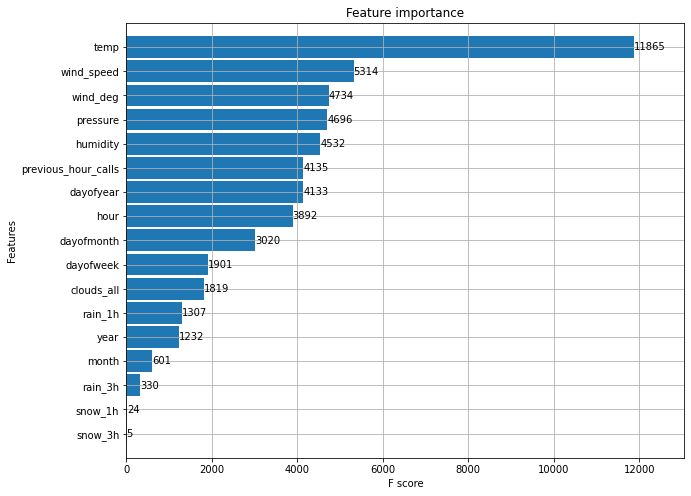

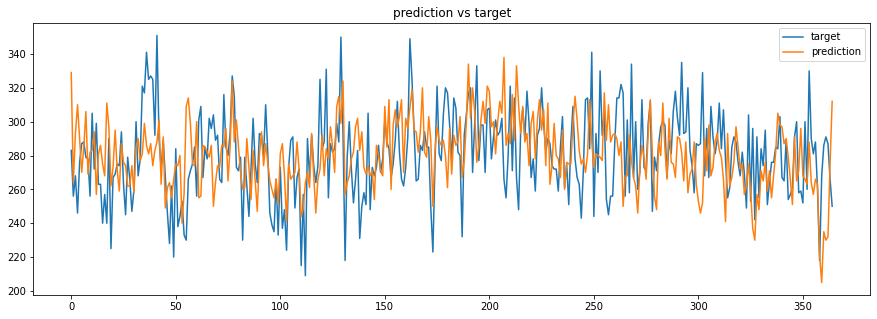

In [11]:
## plotting the importance of features
from matplotlib import pyplot
import numpy as np

class Plotting:
    def __init__(self, prediction, target, description, xgb):
        self.prediction = prediction
        self.target = target
        self.description = description
        self.xgb = xgb
    
    def start_plotting(self):
        self.print_errors()
        self.plot_feature_importance()
        self.plot_back_testing()
    
    def print_errors(self):
        self.preds_day = np.add.reduceat(self.prediction, np.arange(0, len(self.prediction), 24))
        self.y_day = np.add.reduceat(self.target, np.arange(0, len(self.target), 24))
        ## calculating RMSE per hour
        print("RMSE per hour",mean_squared_error(self.target, self.prediction, squared=False))
        ## print RMSE day wise
        print("RMSE per day",mean_squared_error(self.y_day, self.preds_day, squared=False))
    
    def plot_feature_importance(self):
        print(self.description)
        fig, ax = pyplot.subplots(figsize=(10,8))
        _ = plot_importance(self.xgb.model, height=0.9, ax=ax)
    
    def plot_back_testing(self):
        ## Plotting around 8k samples is not going to be useful visually
        ## We can plot results of each day instead of the hours
        pyplot.figure(figsize=(15,5))
        pyplot.title("prediction vs target")
        pyplot.plot(self.y_day , label='target')
        pyplot.plot(self.preds_day, label='prediction')
        pyplot.legend()


Plot = Plotting(predictions, target, 'xgb model which contains previous_calls as features. It exludes weather description feature as it was incearing feature space and was not of importance', xgb)
Plot.start_plotting()
